In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))

32033


In [3]:
# mappings string <-> integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for word in words:
    context = [0] * block_size
    for char in word + '.':
      index = stoi[char]
      X.append(context)
      Y.append(index)
      context = context[1:] + [index] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train,  Y_train  = build_dataset(words[:n1])     # 80%
X_dev, Y_dev = build_dataset(words[n1:n2])   # 10%
X_test,  Y_test  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(X_train[:20], Y_train[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [17]:
class Linear:
    
    def __init__(self, num_of_inputs, num_of_neurons, bias = True):
        self.weight = torch.randn((num_of_inputs, num_of_neurons)) / num_of_inputs**0.5 # kaiming init
        self.bias = torch.zeros(num_of_neurons) if bias else None

    def __call__(self, inputs):
        self.out = inputs @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (for training)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (for validating/testing)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, batch):
        # forward pass
        if self.training:
            if batch.ndim == 2:
                dim = 0
            elif batch.ndim == 3:
                dim = (0, 1)
            batch_mean = batch.mean(0, keepdim=True)
            batch_var = batch.var(0, keepdim=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var
        
        batch_norm = (batch - batch_mean) / torch.sqrt(batch_var + self.eps)
        self.out = self.gamma * batch_norm + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
    
class Tanh:

    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, index):
        self.out = self.weight[index]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# -----------------------------------------------------------------------------------------------

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------------------

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, input):
        for layer in self.layers:
            input = layer(input)
        self.out = input
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [18]:
torch.manual_seed(42); # seed rng for reproducibility

In [19]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [20]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  X_batch, Y_batch = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  logits = model(X_batch)
  loss = F.cross_entropy(logits, Y_batch) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3156
  10000/ 200000: 2.1276
  20000/ 200000: 2.1327
  30000/ 200000: 2.4637
  40000/ 200000: 2.1994
  50000/ 200000: 1.7566
  60000/ 200000: 2.2326
  70000/ 200000: 1.8727
  80000/ 200000: 1.7358
  90000/ 200000: 2.0518
 100000/ 200000: 1.7715
 110000/ 200000: 2.0056
 120000/ 200000: 1.6698
 130000/ 200000: 1.8512
 140000/ 200000: 1.8028
 150000/ 200000: 1.8348
 160000/ 200000: 1.8596
 170000/ 200000: 1.6995
 180000/ 200000: 1.7317
 190000/ 200000: 1.9936


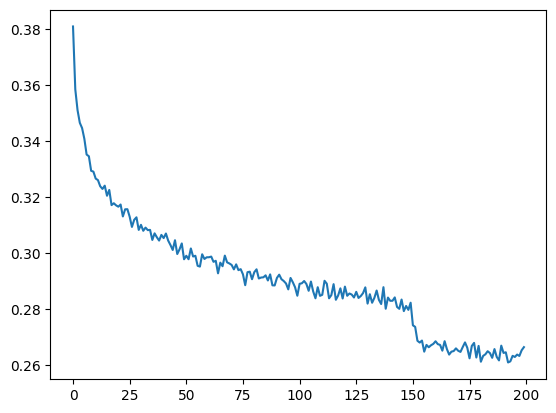

In [21]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [22]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [23]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8147691488265991
val 1.9953093528747559


In [24]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

aneljah.
otto.
headon.
javye.
meladjwan.
amylie.
broxlee.
graylen.
stibot.
abrarda.
astanny.
annay.
brishan.
jayce.
nodine.
remit.
dawye.
genicion.
teagan.
carlyn.
